# HW02: Tokenization

In [31]:
!date

公曆 20廿一年 三月 五日 週五 十五時十三分七秒


In [32]:
#Import the AG news dataset (same as hw01)
#Download them from here 
#!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

In [150]:
import pandas as pd
import numpy as np

from more_itertools import first
from inclusive import range
from plox import Plox

In [34]:
import nltk

In [35]:
df = pd.read_csv('train.zip')

df.columns = ["label", "title", "lead"]
label_map = {1: "world", 2: "sport", 3: "business", 4: "sci/tech"}
df["label"] = df["label"].map(label_map) 
df["text"] = df["title"] + " " + df["lead"]
df.head()

,label,title,lead,text
0,business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
1,business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
2,business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
3,business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."
4,business,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...,"Stocks End Up, But Near Year Lows (Reuters) Re..."


## Preprocess Text

In [36]:
# Subsample
dfs = df.sample(50, random_state=1)

In [37]:
import spacy

## use spacy to split the documents in the sampled dataframe (dfs) in sentences and tokens
## print the first sentence of the first document in your sample

# requires: python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

# Following the quick-start on https://spacy.io/
def split(text: str):
    doc = nlp(text)
    return pd.Series({
        'sentences': list(doc.sents),
        'tokens': list(doc),
    })

In [38]:
# To split all documents:
dfs.split_docs = dfs.text.apply(split)

# First sentence of the first doc
s = first(first(dfs.split_docs.sentences)) 
print(s)

Minority Liberals to oppose Bloc amendment, put government on line (Canadian Press)


In [39]:
## create a new column with tokens in lowercase (x.lower()), with no punctuation (x.is_punct) nor stopword (x.is_digit)

dfs['lowkens'] = dfs.split_docs.tokens.apply(
    lambda tokens: 
    (
        [
            t.text.lower() 
            for t in tokens
            if not (t.is_digit or t.is_punct)
        ]
    )
)

print(first(dfs.lowkens))

['minority', 'liberals', 'to', 'oppose', 'bloc', 'amendment', 'put', 'government', 'on', 'line', 'canadian', 'press', 'canadian', 'press', 'ottawa', 'cp', 'paul', 'martin', "'s", 'minority', 'government', 'is', 'set', 'to', 'put', 'its', 'political', 'life', 'on', 'the', 'line', 'thursday', 'by', 'opposing', 'a', 'bloc', 'quebecois', 'amendment', 'to', 'the', 'throne', 'speech']


In [40]:
## print the tokens (x.lemma_) and the tags (x.tag_ ) of the first sentence of the first document (doc.sents)

pd.DataFrame(
    columns=['lemma', 'tag'],
    data=[(t.lemma_, t.tag_) for t in first(split(first(dfs.text)).sentences)],
).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
lemma,Minority,Liberals,to,oppose,Bloc,amendment,",",put,government,on,line,(,Canadian,Press,)
tag,NNP,NNPS,TO,VB,NNP,NN,",",VBD,NN,IN,NN,-LRB-,NNP,NNP,-RRB-


### Noun Chunks

In [41]:
## print the first 20 noun chunks in your sample corpus (doc.noun_chunks)
from tcga.utils import at_most_n, from_iterable
print(list(at_most_n(from_iterable(nlp(text).noun_chunks for text in dfs.text), 20)))

[Minority Liberals, Bloc amendment, government, line, Canadian Press, Canadian Press - OTTAWA, (CP, Paul Martin's minority government, its political life, the line, a Bloc Quebecois amendment, the throne speech, Montana, Bison Hunting, AP, AP, a spring day, chaos, the border, Yellowstone National Park]


### Named Entities

Let's compute the ratio of named entities starting with a capital letter, e.g. if we have "University of Chicago" as a NE, "University" and "Chicago" are capitalized, "of" is not, thus the ratio is 2/3.

In [42]:
# First text in the subcorpus
doc = nlp(first(dfs.text))
print(*doc, sep=",")
# IOB code of named entity tag. 3 means the token begins an entity, 2 means it is outside an entity, 1 means it is inside an entity, and 0 means no entity tag is set.
# https://spacy.io/api/token
token = list(doc)[12]
print(F"'{token}'", "has IOB code", token.ent_iob)

Minority,Liberals,to,oppose,Bloc,amendment,,,put,government,on,line,(,Canadian,Press,),Canadian,Press,-,OTTAWA,(,CP,),-,Paul,Martin,'s,minority,government,is,set,to,put,its,political,life,on,the,line,Thursday,by,opposing,a,Bloc,Quebecois,amendment,to,the,throne,speech,.
'Canadian' has IOB code 3


In [43]:
## print the ratio of tokens being part of a named entity span starting with a capital letter (doc.ents)

# Don't know what this means
# For each entity? For each token? Averaged? For each token that is part of an entity?

In [29]:
# Only among tokens that belong to an entity

entities = [e for text in dfs.text for sent in nlp(text).sents for e in sent.ents]

df_ents = pd.DataFrame(
    columns=["entity", "token", "first_token", "is_entity_capital"],
    data=[(ent, t, first(ent), first(ent).text[0].isupper()) for ent in entities for t in ent],
)

print(df_ents.head(20))
print("Among tokens in an entity, the fraction whose entity is capitalized: {:.2f}%".format(df_ents.is_entity_capital.mean() * 100))

                          entity     token first_token  is_entity_capital
0              (Canadian, Press)  Canadian    Canadian               True
1              (Canadian, Press)     Press    Canadian               True
2   (Canadian, Press, -, OTTAWA)  Canadian    Canadian               True
3   (Canadian, Press, -, OTTAWA)     Press    Canadian               True
4   (Canadian, Press, -, OTTAWA)         -    Canadian               True
5   (Canadian, Press, -, OTTAWA)    OTTAWA    Canadian               True
6             (Paul, Martin, 's)      Paul        Paul               True
7             (Paul, Martin, 's)    Martin        Paul               True
8             (Paul, Martin, 's)        's        Paul               True
9                     (Thursday)  Thursday    Thursday               True
10              (Montana, Moves)   Montana     Montana               True
11              (Montana, Moves)     Moves     Montana               True
12      (Resume, Bison, Hunting)    Re

In [53]:
# Now among all tokens

dfs['docs'] = dfs.text.apply(nlp)

# The dictionary maps the token index to its entity, if applicable
def get_i2e(ents):
    return dict((i, e) for e in ents for i in range(e.start, e.end))

# Example
# doc = first(dfs['docs'])
# print(get_i2e(doc.ents)) # {12: Canadian Press, 13: Canadian Press, 15: Canadian Press - OTTAWA,  ...}
# print(doc[12], doc[13]) # Canadian Press

dfs['i2e'] = dfs.docs.apply(lambda doc: get_i2e(doc.ents))

get_i2e((list(first(dfs.docs).sents)[1]).ents)

df_ents = pd.DataFrame(
    columns=("token", "starts_sentence", "is_in_entity", "entity", "is_entity_capital"),
    data=(
        (t, t.is_sent_start, i in i2e, i2e.get(i), (first(i2e[i]).text[0].isupper() if (i in i2e) else False))
        for (doc, i2e) in zip(dfs.docs, dfs.i2e)
        for (i, t) in enumerate(doc)
    )
)

print(df_ents[['token', 'is_in_entity', 'is_entity_capital']].head(16))
print("Among all tokens, the fraction in a capitalized entity: {:.2f}%".format(df_ents.is_entity_capital.mean() * 100))

# We get the previous result (71%) with 
#df_ents.is_entity_capital[df_ents.is_in_entity].mean()

         token  is_in_entity  is_entity_capital
0     Minority         False              False
1     Liberals         False              False
2           to         False              False
3       oppose         False              False
4         Bloc         False              False
5    amendment         False              False
6            ,         False              False
7          put         False              False
8   government         False              False
9           on         False              False
10        line         False              False
11           (         False              False
12    Canadian          True               True
13       Press          True               True
14           )         False              False
15    Canadian          True               True
Among all tokens, the fraction in a capitalized entity: 18.07%


In [54]:
## print the ratio of capitalized tokens not being part of a named entity span
# e.g. "The dog barks" = 1/3; 3 tokens, only "The" is capitalized

df_ents['is_cap'] = df_ents.token.apply(lambda t: t.text[0].isupper())

print("Among all capitalized tokens, the fraction not in an entity: {:.2f}%".format(np.mean(~df_ents[df_ents.is_cap].is_in_entity) * 100))

Among all capitalized tokens, the fraction not in an entity: 28.08%


In [64]:
## print the ratio of capitalized tokens not being a named entity and not being the first token in a sentence
# e.g. "The dog barks" = 0; 3 tokens, "The" is capitalized but the starting token of a sentence, no other tokens are capitalized.

x = np.mean(~df_ents[df_ents.is_cap].is_in_entity & ~df_ents[df_ents.is_cap].starts_sentence)
print(f"Among capitalized tokens, fraction not in entity nor sentence start: {(x * 100):.2f}%")


Among capitalized tokens, fraction not in entity nor sentence start: 21.06%


In [83]:
## Give an example of a capitalized token in the data which is neither a named entity nor at the start of a sentence. What could be the reason the token is capitalized (one sentence)?

print(df_ents[df_ents.is_cap & ~df_ents.is_in_entity & ~df_ents.starts_sentence].token)

1        Liberals
4            Bloc
20             CP
42           Bloc
43      Quebecois
          ...    
2151       Martin
2159         Jets
2194      Hooters
2228     Partners
2229         With
Name: token, Length: 123, dtype: object
Canadian Press - OTTAWA (CP) - Paul Martin's minority government is set to put its political life on the line Thursday by opposing a Bloc Quebecois amendment to the throne speech.
Cards vs. Jets quarter-by-quarter Carter returned, but it was running back Curtis Martin and the offensive line that put the Jets ahead.
Martin rushed for all but 10 yards of a 45-yard drive that stalled at the Cardinals 10.


In [89]:
## What could be the reason the token is capitalized (one sentence)?

# I suppose these are abbreviations or not recognized as a named entity or silly capitalizations
# Don't know about "Martin", though?

assert(0 == len(nlp("Quebecois").ents))
assert(1 == len(nlp("Martin").ents))

# A sentence with 'Martin':
print(*[
        (sent, sent.ents)
        for doc in dfs.docs
        for sent in doc.sents
        if "Martin" in list(map(str, sent))
        if "Martin" not in "".join(map(str, sent.ents))
    ],
    sep="\n"
)

# I don't understand this sentence
# Incidentally, I suppose "Cards" is a named entity here
# Also, "quarter-by-quarter Carter", maybe

(Cards vs. Jets quarter-by-quarter Carter returned, but it was running back Curtis Martin and the offensive line that put the Jets ahead., [Jets quarter-by-quarter, Carter])


## Term Frequencies

business


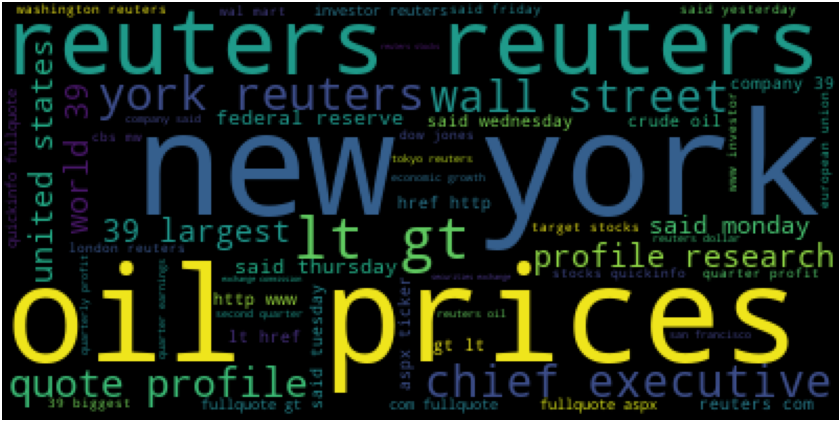

sci/tech


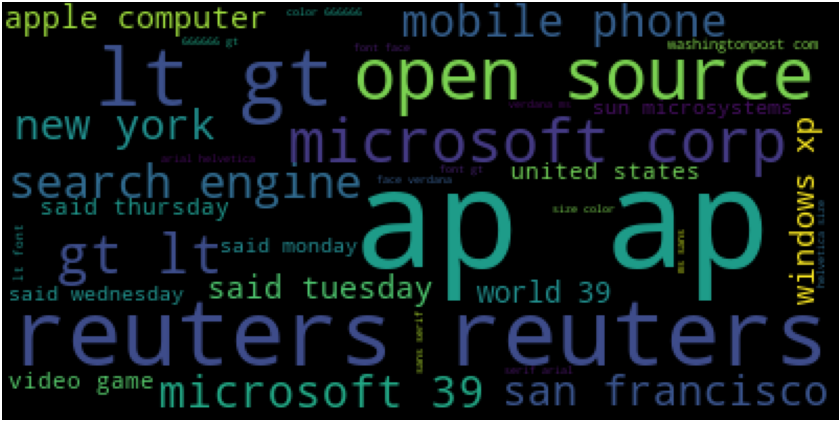

sport


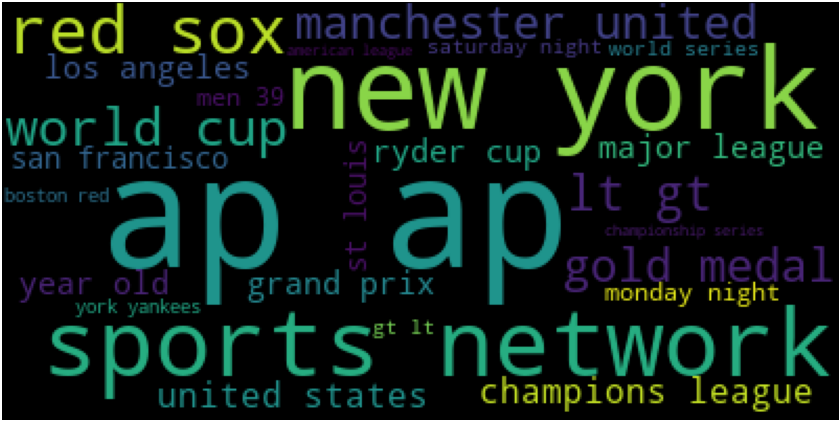

world


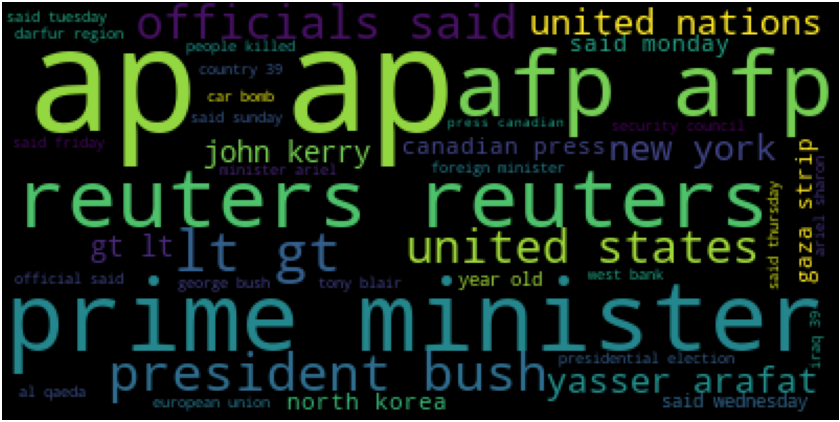

In [152]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=0.01, 
                        max_df=0.9,  
                        max_features=1000,
                        stop_words='english',
                        use_idf=True, # the new piece
                        ngram_range=(2,2))
                    
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
# Only applies if analyzer is not callable

## using the whole sample, produce a world cloud with bigrams for each label using tfidf frequencies

from wordcloud import WordCloud
import matplotlib.pyplot as plt

for (label, texts) in df.text.groupby(df.label):
    print(label)
    X = tfidf.fit_transform(list(texts))
    f = dict(zip(tfidf.get_feature_names(), np.sum(X, axis=0).tolist().pop()))
    wc = WordCloud().fit_words(f)
    with Plox() as px:
        px.a.imshow(wc)
        px.a.axis('off')
        px.show()


## Hash Vectorizer

In [167]:
from sklearn.feature_extraction.text import HashingVectorizer

hv = HashingVectorizer(n_features=5000)

## print the first 10 features produced by the hash vectorizer

# ?

for (label, texts) in df.text.groupby(df.label):
    X = hv.fit_transform(list(texts))
    print(pd.DataFrame(X[:, 0:10].todense()))

         0    1    2    3    4    5    6    7    8    9
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
29994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
29995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
29996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
29997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
29998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[29999 rows x 10 columns]
         0    1    2    3    4    5    6    7    8    9
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4      0.0  0.0  0.0 

In [175]:
# Based on the notebook from course and https://stackoverflow.com/a/41109860/

#!pip install eli5
from eli5.sklearn import InvertableHashingVectorizer

ivec = InvertableHashingVectorizer(hv)
for (label, texts) in df.text.groupby(df.label):
    inverted_hv = ivec.fit(texts)
    print("Label:", label)
    #print("Feature names:", pd.DataFrame(inverted_hv.get_feature_names()))
    # Don't know what we're looking at, hence omitted

Label: business
Label: sci/tech
Label: sport
Label: world


## Supervised Feature Selection

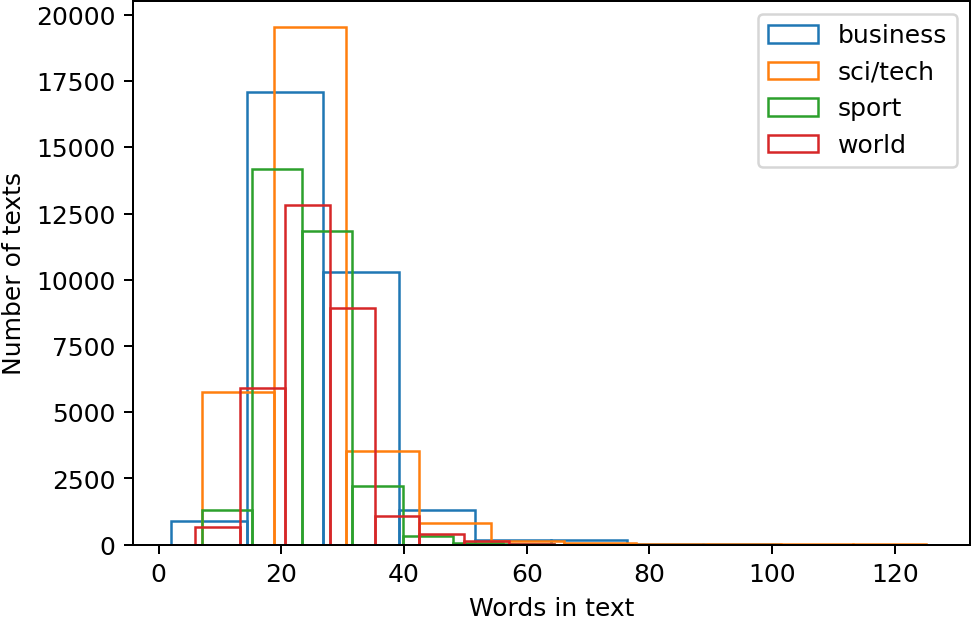

In [196]:
## compute the number of words per document (excluding stopwords)

from sklearn.feature_extraction.text import CountVectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# "There are several known issues with 'english' and you should consider an alternative"
cv = CountVectorizer(stop_words='english')

words_per_text = pd.Series(
    index=df.label,
    data=np.asarray(cv.fit_transform(df.text).sum(axis=1)).squeeze(),
)

with Plox() as px:
    for (i, (label, counts)) in enumerate(words_per_text.groupby(words_per_text.index)):
        px.a.hist(counts, facecolor='none', edgecolor=F'C{i}', label=label)
    px.a.legend()
    px.a.set_xlabel("Words in text")
    px.a.set_ylabel("Number of texts")
    px.show()


In [286]:
## get the most predictive features of the number of words per document using first f_class and then chi2
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# Most predicitive among which features?

cv = CountVectorizer(stop_words='english')
X = cv.fit_transform(df.text)

# Following 02_ngrams.ipynb...

for foobar in [f_classif, chi2]:

    select = SelectKBest(foobar, k=10)
    select.fit_transform(X, words_per_text)

    df_cv = pd.DataFrame(
        {
            'word': cv.get_feature_names(),
            'score': select.scores_,
        }
    )

    df_cv = df_cv.replace([np.inf], np.nan).dropna().sort_values(by='score')

    print(foobar.__name__, ":", *df_cv.word[df_cv.score.nsmallest(10).index])


f_classif : meteorological interpretations manufactures dwango healed submariner guerillas billowing moyes cyclones
chi2 : meteorological interpretations manufactures healed submariner guerillas billowing cyclones staffs workload


Are the results different? What could be a reason for this? 

--

Somewhat different. Don't know why.

## Huggingface Tokenizers

In [284]:
# # we use distilbert tokenizer
from transformers import DistilBertTokenizerFast

# let's instantiate a tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

tokenize = (lambda text: tokenizer(text, return_token_type_ids=True, return_attention_mask=False))

## tokenize the sentences in the sampled dataframe (dfs) using the DistilBertTokenizer
# note: tokenizing texts, not sentences
tokenized = pd.DataFrame(data=[tokenize(text) for text in dfs.text])

## what is the type/token ratio from this tokenizer (number_of_unique_token_types/number_of_tokens)?
from collections import Counter
number_of_unique_token_types = len(Counter(from_iterable(tokenized.token_type_ids)))

if (1 == number_of_unique_token_types):
    print("There is only one token type.")
else:
    print(f"There are {number_of_unique_token_types} token types.")

number_of_unique_tokens = len(Counter(from_iterable(tokenized.input_ids)))
print(f"There are {number_of_unique_tokens} unique tokens.")

## what is the amount of subword tokens returned by the huggingface tokenizer? hint: each subword token starts with "#"
# Assume double-hash as subword marker
subword_tokens = dfs.text.apply(tokenizer.tokenize).apply(lambda T: sum(t.startswith("##") for t in T)).sum()
print(f"Subword tokens: {subword_tokens}")


There is only one token type.
There are 1116 unique tokens.
Subword tokens: 163
